In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.models import model_from_json

import numpy as np
import pandas as pd
import tensorflow as tf
import bcolz
import threading

import os
import sys
import glob
import shutil

from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [25]:
# load json and create model
json_file = open('best_models/simple2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("best_models/simple2_best.h5")
print("Loaded model from disk")

Loaded model from disk


In [26]:
def file_path_from_db_id(db_id, pattern="%d.bmp", top="/home/pepe/projects/tesis/datasets/dataset/"):
    s = '%09d' % db_id
    return os.path.join(top, pattern % db_id)

In [27]:
def generator_from_df(df, batch_size, target_size, target_column='target', features=None, process=True):

    nbatches, n_skipped_per_epoch = divmod(df.shape[0], batch_size)
    #print nbatches
    count = 1
    epoch = 0
    # New epoch.
    while 1:
        df = df.sample(frac=1) # shuffle in every epoch
        epoch += 1
        i, j = 0, batch_size
        # Mini-batches within epoch.
        mini_batches_completed = 0
        for _ in range(nbatches):
            sub = df.iloc[i:j]
            try:
                if process == True:
                    X = np.array([(2 * (img_to_array(load_img(f, target_size=target_size)) / 255.0 - 0.5)) for f in sub.imgpath])
                else:
                    X = np.array([((img_to_array(load_img(f, target_size=target_size)))) for f in sub.imgpath])
                    
                Y = sub[target_column].values
                # Simple model, one input, one output.
                mini_batches_completed += 1
                yield X, Y

            except IOError as err:
                count -= 1

            i = j
            j += batch_size
            count += 1

In [28]:
dataset = pd.read_csv('/home/pepe/projects/tesis/datasets/dataset/target.csv')
dataset['imgpath'] = dataset.id.apply(file_path_from_db_id)
train, test = train_test_split(dataset, test_size=0.2)

In [29]:
def custom_loss(y_true, y_pred):
    
    loss = tf.square(y_true - y_pred)
    loss = .5 * tf.reduce_mean(loss)
    return loss

In [21]:
model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
#score = model.evaluate_generator(generator_from_df(test, 8, (80,160), 'angular'), steps=77)
score = model.evaluate_generator(generator_from_df(test, 8, (224,224), 'angular'), steps=77)

In [30]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
score = model.evaluate_generator(generator_from_df(test, 8, (224,224), 'angular'), steps=77)

In [31]:
score

[0.05880247197392118, 0.29383116883116883]

In [32]:
np.set_printoptions(precision=3, suppress=True)
gen = generator_from_df(test, 1, (224,224), 'angular')
for i in range(20):
    x, target = gen.next()
    goal = target.flatten()
    pred = model.predict(x).flatten()
    print str(goal).rjust(8), '\t',pred, '=>\t'.ljust(5), np.abs(goal - pred), '\t\tx' if np.sign(goal) != np.sign(pred) else '\t\t/'


 [0.487] 	[0.459] =>	   [0.029] 		/
 [0.289] 	[0.26] =>	   [0.029] 		/
[-0.164] 	[-0.534] =>	   [0.37] 		/
[-0.126] 	[-0.151] =>	   [0.025] 		/
[-0.009] 	[0.018] =>	   [0.027] 		x
[-0.992] 	[-0.906] =>	   [0.086] 		/
 [0.021] 	[0.078] =>	   [0.056] 		/
 [0.142] 	[0.222] =>	   [0.08] 		/
[-0.471] 	[-0.481] =>	   [0.009] 		/
 [0.989] 	[0.94] =>	   [0.049] 		/
 [0.142] 	[0.162] =>	   [0.02] 		/
[-0.265] 	[-0.247] =>	   [0.018] 		/
[-0.176] 	[0.054] =>	   [0.23] 		x
 [0.355] 	[0.378] =>	   [0.023] 		/
   [-1.] 	[-0.82] =>	   [0.18] 		/
    [1.] 	[0.983] =>	   [0.017] 		/
 [0.728] 	[0.794] =>	   [0.066] 		/
   [-1.] 	[-0.963] =>	   [0.037] 		/
 [0.114] 	[0.244] =>	   [0.13] 		/
[-0.747] 	[-0.387] =>	   [0.36] 		/


### visualizacion de capas

[-1.]


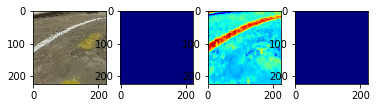

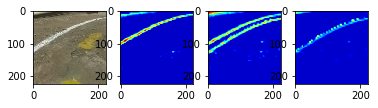

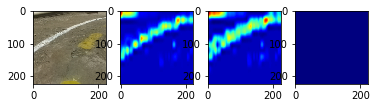

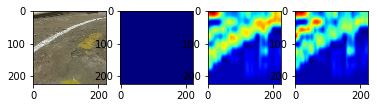

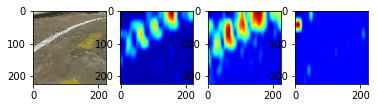

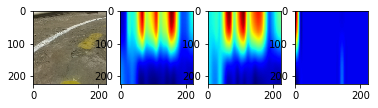

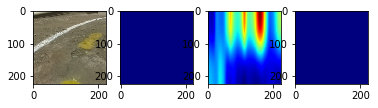

In [41]:
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay
from vis.visualization import visualize_cam
test_gen = generator_from_df(test, 1, (224,224), 'angular', process=False)
ex_im, ex_tg = test_gen.next()
ex_im = ex_im[0]
ex_im = (ex_im)*255
print ex_tg
for j in range(-7,-0):  
    plt.figure()
    plt.title('original')
    plt.subplot(141)
    plt.imshow(ex_im)
    bgr_img = ex_im
    titles = ['left', 'mantain', 'right']
    modifiers = [None, 'small_values', 'negate']

    for i, modifier in enumerate(modifiers):
        heatmap = visualize_cam(model, layer_idx=j, filter_indices=0, 
                                     seed_input=bgr_img, grad_modifier=modifier)
        #print heatmap.shape, bgr_img.shape
        #plt.figure()
        #plt.title(titles[i])
        # Overlay is used to alpha blend heatmap onto img.
        #plt.imshow(overlay(bgr_img, heatmap, alpha=0.7))
        plt.subplot(142 + i)
        plt.imshow(heatmap)